In [42]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

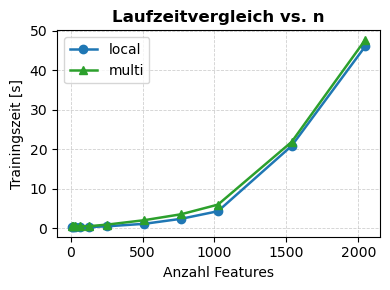

Grafik gespeichert: ../img/runtime_vs_n.png


In [50]:
files = {
    "local": "../stats/local-var_fts.csv",
    "multi": "../stats/multi-var_fts.csv",
}

dfs = []
for label, path in files.items():
    df = pd.read_csv(path)
    dfs.append(df)

plt.figure(figsize=(4, 3))

styles = {
    "local":  dict(marker="o", linestyle="-", linewidth=1.8),
    # "single": dict(marker="s", linestyle="-", linewidth=1.8),
    "multi":  dict(marker="^", linestyle="-", linewidth=1.8),
}

colors = {
    "local": "tab:blue",
    # "single": "tab:orange",
    "multi": "tab:green",
}

for df in dfs:
    label = df["mode"].iloc[0]
    plt.plot(df["n_features"], df["t_fit_ms"]/1000, label=label, color=colors[label], **styles[label])


plt.xlabel("Anzahl Features")
plt.ylabel("Trainingszeit [s]")
plt.title("Laufzeitvergleich vs. n", fontweight="bold")
plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)
plt.legend()
# plt.xscale("log")
# plt.yscale("log")
plt.tight_layout()
out = "../img/runtime_vs_n.png"
plt.savefig(out, dpi=300)
plt.show()
print(f"Grafik gespeichert: {out}")

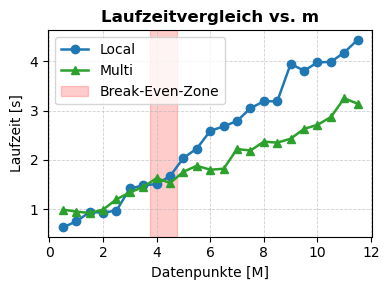

Grafik gespeichert: ../img/runtime_vs_m.png


In [49]:
import pandas as pd
import matplotlib.pyplot as plt

break_even_min = 3.75
break_even_max = 4.75

files = {
    "local": "../stats/local-var_dpts.csv",
    "multi": "../stats/multi-var_dpts.csv",
}

# Daten laden
df = pd.DataFrame()
for label, path in files.items():
    df_temp = pd.read_csv(path)
    df["m_datapoints"] = df_temp["m_datapoints"]
    df[label] = df_temp["t_fit_ms"]/1000

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(4, 3))

styles = {
    "local": dict(marker="o", linestyle="-", linewidth=1.8),
    "multi": dict(marker="^", linestyle="-", linewidth=1.8),
}
colors = {
    "local": "tab:blue",
    "multi": "tab:green",
}

# Laufzeiten plotten
ax1.plot(df["m_datapoints"]/1e6, df["local"], label="Local", color=colors["local"], **styles["local"])
ax1.plot(df["m_datapoints"]/1e6, df["multi"], label="Multi", color=colors["multi"], **styles["multi"])

ax1.set_xlabel("Datenpunkte [M]")
ax1.set_ylabel("Laufzeit [s]")
ax1.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.6)

# Break-Even-Zone einzeichnen
ax1.axvspan(break_even_min, break_even_max, color="red", alpha=0.2, label="Break-Even-Zone")

# Legende
ax1.legend(loc="upper left")

plt.title("Laufzeitvergleich vs. m", fontweight="bold")
plt.tight_layout()

out = "../img/runtime_vs_m.png"
plt.savefig(out, dpi=300)
plt.show()
print(f"Grafik gespeichert: {out}")

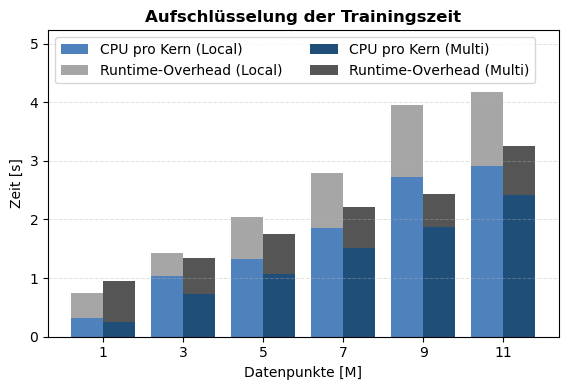

Grafik gespeichert: ../img/fitting_time.png


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Dateien laden
df_multi = pd.read_csv("../stats/multi-var_dpts.csv")
df_local = pd.read_csv("../stats/local-var_dpts.csv")

# CPU pro Kern + Overhead berechnen (inkl. GC) und in Sekunden umrechnen
for df in [df_multi, df_local]:
    cpu_per_core_ms = df["cpu_ms"] / 4
    df["cpu_s"] = cpu_per_core_ms / 1000.0
    df["overhead_s"] = (df["t_fit_ms"] - cpu_per_core_ms) / 1000.0

# Nur bestimmte m_datapoints auswählen
allowed = [1_000_000, 3_000_000, 5_000_000, 7_000_000, 9_000_000, 11_000_000]
df_multi = df_multi[df_multi["m_datapoints"].isin(allowed)].sort_values("m_datapoints")
df_local = df_local[df_local["m_datapoints"].isin(allowed)].sort_values("m_datapoints")

# Achsen vorbereiten
x = np.arange(len(df_multi))
width = 0.4

cpu_multi = df_multi["cpu_s"].to_numpy()
ovh_multi = df_multi["overhead_s"].to_numpy()

cpu_local = df_local["cpu_s"].to_numpy()
ovh_local = df_local["overhead_s"].to_numpy()

# Farbpalette: Multi = dunkler, Local = heller
colors_multi = {
    "cpu": "#1f4e79",   # dunkles Blau
    "ovh": "#555555"    # dunkles Grau
}
colors_local = {
    "cpu": "#4f81bd",   # helleres Blau
    "ovh": "#a6a6a6"    # helleres Grau
}

# ---- Plot
fig, ax = plt.subplots(figsize=(6, 4))

# Local (linke Balken je Gruppe)
ax.bar(x - width/2, cpu_local, width, label="CPU pro Kern (Local)", color=colors_local["cpu"])
ax.bar(x - width/2, ovh_local, width, bottom=cpu_local, label="Runtime-Overhead (Local)", color=colors_local["ovh"])

# Multi (rechte Balken je Gruppe)
ax.bar(x + width/2, cpu_multi, width, label="CPU pro Kern (Multi)", color=colors_multi["cpu"])
ax.bar(x + width/2, ovh_multi, width, bottom=cpu_multi, label="Runtime-Overhead (Multi)", color=colors_multi["ovh"])


# Achsen & Beschriftungen
ax.set_xticks(x)
ax.set_xticklabels((df_multi["m_datapoints"]/1e6).astype(int).astype(str), rotation=0)
ax.set_xlabel("Datenpunkte [M]")
ax.set_ylabel("Zeit [s]")
ax.set_title("Aufschlüsselung der Trainingszeit", fontweight="bold")

# Y-Limit automatisch mit Puffer
ymax = max(
    (cpu_multi + ovh_multi).max(),
    (cpu_local + ovh_local).max()
)
ax.set_ylim(0, ymax * 1.25)

# Horizontale Hilfslinien
ax.grid(axis="y", linestyle="--", alpha=0.4, linewidth=0.7)

# Legende
ax.legend(ncol=2, loc="upper left")

plt.tight_layout()

out = "../img/fitting_time.png"
plt.savefig(out, dpi=300)
plt.show()
print(f"Grafik gespeichert: {out}")